In [1]:
%matplotlib inline
import numpy as np
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-tf-distribution-options'
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-east-1-441707470931


In [2]:
!python generate_cifar10_tfrecords.py --data-dir ./data

W0823 02:59:32.272346 140683125491520 deprecation_wrapper.py:119] From generate_cifar10_tfrecords.py:35: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0823 02:59:32.272576 140683125491520 deprecation_wrapper.py:119] From generate_cifar10_tfrecords.py:35: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ./data/validation/validation.tfrecords
Generating ./data/eval/eval.tfrecords
Done!


In [3]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='data2/tf-distribution-options')
display(inputs)

's3://sagemaker-us-east-1-441707470931/data2/tf-distribution-options'

In [4]:
from sagemaker.tensorflow import TensorFlow

ps_instance_type = 'ml.m4.xlarge'
ps_instance_count = 2

model_dir = "/opt/ml/model"

distributions = {'parameter_server': {
                    'enabled': True}
                }
hyperparameters = {'epochs': 100, 'batch-size' : 1, 'learning-rate': '0.01'}

estimator_ps = TensorFlow(base_job_name='ps-cifar10-tf',
                       source_dir='code',
                       entry_point='train_lr.py', 
                       role=role,
                       framework_version='1.13',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=ps_instance_count, 
                       train_instance_type=ps_instance_type,
                       model_dir=model_dir,
                       tags = [{'Key' : 'Project', 'Value' : 'lr'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

In [5]:
remote_inputs = {'train' : inputs+'/train', 'validation' : inputs+'/validation', 'eval' : inputs+'/eval'}
estimator_ps.fit(remote_inputs, wait=True)

2019-08-23 02:59:57 Starting - Starting the training job...
2019-08-23 02:59:58 Starting - Launching requested ML instances.........
2019-08-23 03:01:32 Starting - Preparing the instances for training......
2019-08-23 03:02:59 Downloading - Downloading input data
2019-08-23 03:02:59 Training - Downloading the training image...
2019-08-23 03:03:18 Training - Training image download completed. Training in progress.
2019-08-23 03:03:20,655 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-08-23 03:03:20,661 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-08-23 03:03:20,675 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-08-23 03:03:20,675 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2019-08-23 03:03:20,675 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
201

In [6]:
import json 

!aws s3 cp {estimator_ps.model_data} ./ps_model/model.tar.gz
!tar -xzf ./ps_model/model.tar.gz -C ./ps_model

with open('./ps_model/ps_history.p', "r") as f:
    ps_history = json.load(f)

download: s3://sagemaker-us-east-1-441707470931/ps-cifar10-tf-2019-08-23-02-59-57-184/output/model.tar.gz to ps_model/model.tar.gz


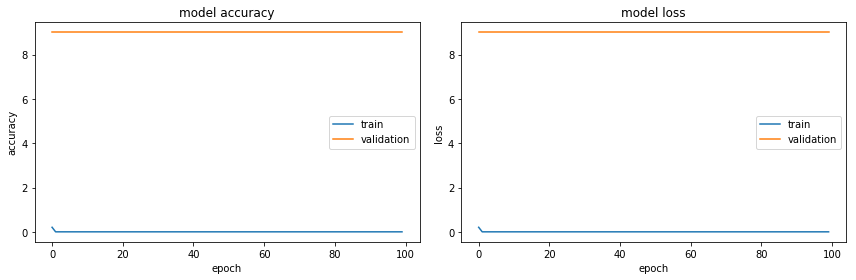

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')
    ax.set(
        title='model accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()

    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(ps_history)